In [8]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models.neurlux import NeurLuxModel
from nebula.models.quovadis import QuoVadisModel
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ["nebula", "neurlux", "quovadis"]
RUN_NAME = "cruparamer"

INFOLDER = "out_cruparamer_5_folds"
DMDS_FOLDER = "out_cruparamer_limit_no_test_5_folds_1682679343\cv_dmds_lim1250_r1763_tNone"

RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]
LIMIT = "full"

VOCAB = 50000
NEURLUX_VOCAB = 10000
QUO_VADIS_VOCAB = 600
SEQ_LEN = 512

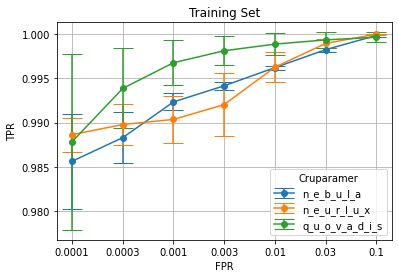

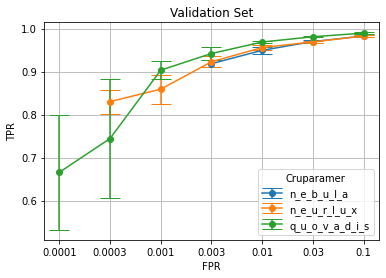

In [9]:
def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[0]

metrics_train = {}
metrics_val = {}
for folder in run_folders:
    metrics_train.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, training_filter))
    metrics_val.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, validation_filter))

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [10]:
from nebula.models.dmds import DMDSGatedCNN

models = defaultdict(dict)

neurlux_vocab_file = os.path.join(INFOLDER, f"neurlux_vocab_{NEURLUX_VOCAB}_seqlen_{SEQ_LEN}", f"vocab_{NEURLUX_VOCAB}.json")
quo_vadis_data_folder = os.path.join(INFOLDER, f"quovadis_vocab_{QUO_VADIS_VOCAB}_seqlen_{SEQ_LEN}")
quo_vadis_vocab_name = [x for x in os.listdir(quo_vadis_data_folder) if x.startswith("vocab")][0]
quovadis_vocab_file = os.path.join(quo_vadis_data_folder, quo_vadis_vocab_name)
nebula_vocab_file = os.path.join(INFOLDER, f"nebula_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_vocab.json")

with open(neurlux_vocab_file) as f:
    neurlux_vocab = json.load(f)
models['neurlux']['class'] = NeurLuxModel
models['neurlux']['config'] = {
    "embedding_dim": 256,
    "vocab_size": len(neurlux_vocab),
    "seq_len": SEQ_LEN,
}

models['quovadis']['class'] = QuoVadisModel
models['quovadis']['config'] = {
    "vocab": quovadis_vocab_file,
    "seq_len": SEQ_LEN
}

with open(nebula_vocab_file) as f:
    nebula_vocab = json.load(f)
models['nebula']['class'] = TransformerEncoderChunks
models['nebula']['config'] = {
    "vocab_size": len(nebula_vocab),
    "maxlen": SEQ_LEN,
    "chunk_size": 64,
    "dModel": 64,  # embedding & transformer dimension
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    "numClasses": 1, # binary classification
    "hiddenNeurons": [64],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False,
    "norm_first": True
}

models['dmds']['class'] = DMDSGatedCNN
models['dmds']['config'] = {
    "ndim": 98,
    "seq_len": 64,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model_files = defaultdict(list)
metrics_val = defaultdict(list)

run_folders.append(DMDS_FOLDER)
for folder in run_folders:
    if folder == DMDS_FOLDER:
        key = "dmds"
    else:
        key = folder.split("_")[1]
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")

        if folder != DMDS_FOLDER:
            folder = os.path.join(INFOLDER, folder)

        data_splits = read_cv_data_splits(folder, splits=5)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        assert len(data_splits) == len(model_files[key]), "Number of splits and models do not match"

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_val)

[*] In process: dmds
[*] Running ROC for split: 0
Evaluating dmds_split_0 | Size: 425537...


100%|██████████| 3/3 [00:00<00:00, 16.45it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 1
Evaluating dmds_split_1 | Size: 425537...


100%|██████████| 3/3 [00:00<00:00, 34.32it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 2
Evaluating dmds_split_2 | Size: 425537...


100%|██████████| 3/3 [00:00<00:00, 73.14it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 3
Evaluating dmds_split_3 | Size: 425537...


100%|██████████| 3/3 [00:00<00:00, 50.80it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 4
Evaluating dmds_split_4 | Size: 425537...


100%|██████████| 3/3 [00:00<00:00, 54.97it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
nebula,0.615567,0.741547,0.833186,0.904220,0.952419,0.969506,0.981905,0.993901,0.993709,0.965275,0.958603,0.972059,0.977000
neurlux,0.732064,0.786553,0.850753,0.923033,0.955905,0.969480,0.982800,0.995003,0.994184,0.968712,0.957995,0.979707,0.979367
quovadis,0.668950,0.746001,0.903500,0.942211,0.968900,0.981200,0.989702,0.994998,0.994957,0.961320,0.972723,0.951688,0.973600
dmds,0.000103,0.000308,0.001026,0.003079,0.010263,0.030788,0.102627,0.307881,0.509508,0.000000,0.000000,0.000000,0.510400


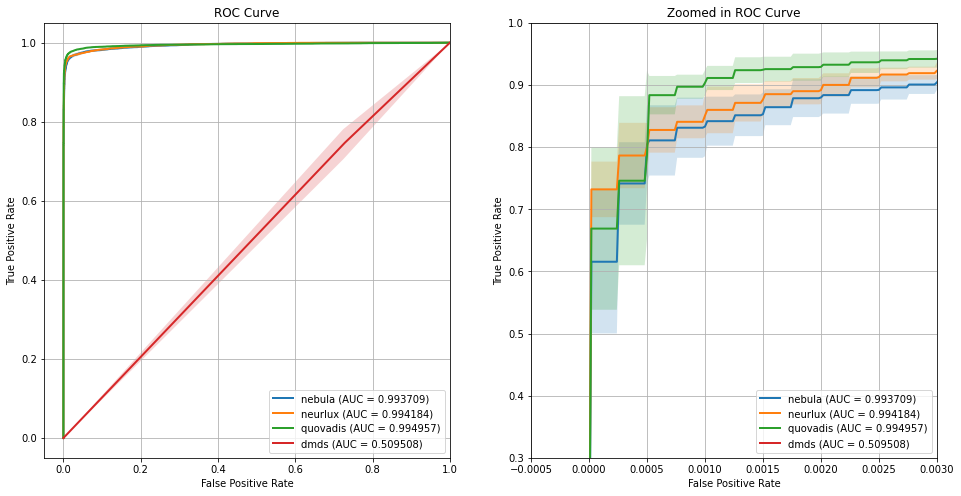

In [12]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val,
    tprs_std_val,
    metrics_val,
    xlim=[-0.0005, 0.003],
    ylim=[0.3, 1.0],
    metrics_full=True
)
df

## Test set ROCs

In [13]:
model_files = defaultdict(list)
metrics_test = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and "vocab" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_test)

[*] In process: cruparamer


IndexError: list index out of range

In [ ]:
df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test,
    tprs_std_test,
    metrics_test,
    metrics_full=True
)
df

NameError: name 'base_fpr_test' is not defined

: 

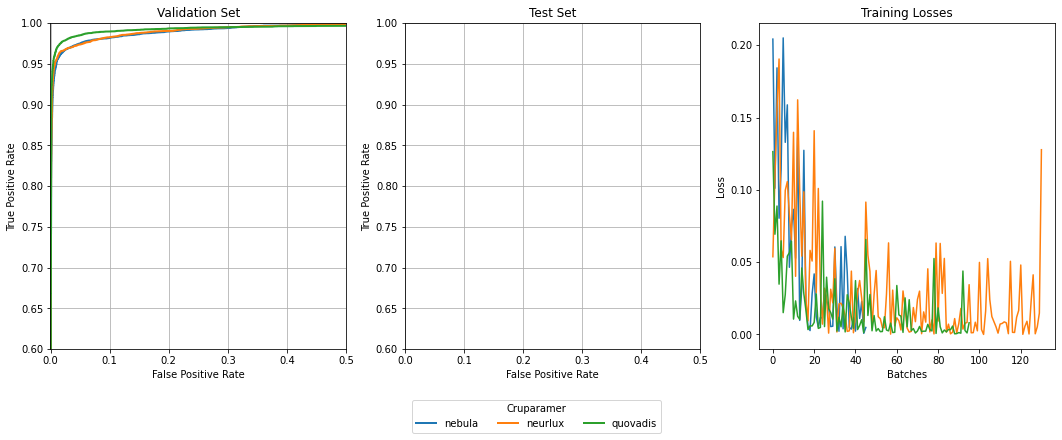

In [ ]:
import matplotlib.pyplot as plt

YLIM = [0.6, 1]
XLIM = [-0.0005, 0.5]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=YLIM, xlim=XLIM)
    plot_roc_curve(base_fpr_test, tprs_mean_test[key], model_name=key, ax=axs[1], ylim=YLIM, xlim=XLIM)

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

start = 200
n = 50
for folder in run_folders:
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    loss_mean = np.load(train_losses)[start::n]    
    axs[2].plot(loss_mean, label=key)
axs[2].set_xlabel("Batches")
axs[2].set_ylabel("Loss")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')